In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize

#potentiall remove at some point
import matplotlib.pylab as pl
import pickle
import pandas as pd


In [2]:
# analytic solution
dt=1
def a(h,lam,mu):
    return mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt))

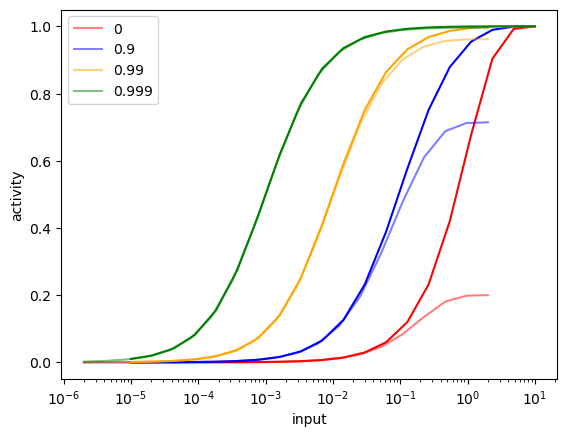

In [3]:
hs=np.logspace(-5,1,20)
colors=['red','blue','orange','green']
for i,lam in enumerate([0,0.9,0.99,0.999]):
    plt.plot(hs*0.2, a(hs, lam, 0.2), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, a(hs, lam, 1.0), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

# Reconstruction of data based on Beta-parameters from fits to numerical distributions

In [ ]:
#TODO

# Step-by-step implementation of measures
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$

and the distribution of output that is formally a convolution of activity and noise simply becomes a shifted Gaussian
$$ P(o) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

### 1. Find smallest $h$ for which the overlap with the zero-input case is less than discrimination error $\varepsilon$
Note: $a(0)=0$ for all $\lambda$ and $\mu$ such that $P(o)=\mathcal{N}(0,\sigma)$

In [78]:
def calc_overlap(pmf1, pmf2):
    """
    calculates the overlap between two discrete probability mass functions
    ATTENTION: needs user to ensure that domains are identical!
    """
    assert len(pmf1) == len(pmf2)
    return np.sum(np.minimum(pmf1, pmf2)) * 0.5


def find_discriminable_inputs(pmf, h_range, epsilon: float, start="left"):
    """
    Determine all inputs h in range h_range such that the overlap between the all pmfs is less than epsilon
    The pmfs of h_range[0] and h_range[1] sever as boundaries

    # Parameter
    - pmf: function
    - h_range: array-like with length two
    - epsilon: float
        discrimination error that specifies maximal overlap between two probability mass functions
    """
    assert len(h_range) == 2
    h_left, h_right = h_range
    hs = []
    if start == "left":
        h_ref = h_left
        pmf_end = pmf(h_right)
    elif start == "right":
        h_ref = h_right
        pmf_end = pmf(h_left)
    pmf_ref = pmf(h_ref)

    while True:

        def func(h):
            return calc_overlap(pmf_ref, pmf(h)) - epsilon

        try:
            if start == "left":
                h_new = optimize.bisect(func, h_ref, h_right)
            elif start == "right":
                h_new = optimize.bisect(func, h_left, h_ref)
            pmf_new = pmf(h_new)
            if calc_overlap(pmf_end, pmf_new) < epsilon:
                hs.append(h_new)
                h_ref = h_new
                pmf_ref = pmf_new
            else:
                break
        except:
            break
    return hs


def dynamic_range(h_range):
    """
    Calculate the dynamic range from the range h_range
    """
    assert len(h_range) == 2
    h_left, h_right = h_range
    return 10 * (np.log10(h_right) - np.log10(h_left))


def mutual_information(p_x_given_y, p_y):
    """
    Calculate the mutual information I(X;Y).

    # Parameters
    - p_x_given_y: func
        function for the conditional probability to observe X given Y
    - p_y: scipy.stats.rv_discrete
        discrete distribution for random variable Y
    """
    # extract support and probabilities from internal structure because API does not allow to get support
    support_y, prob_y = p_y._ctor_param["values"]
    # precalculate matrix of conditional probabilities P(X|Y) with shape (x,y)
    matrix_x_given_y = np.array([p_x_given_y(y) for y in support_y]).T
    # P(x) is sum_j p(y_j)*p(x|_y_j)
    prob_x = np.sum(np.multiply(matrix_x_given_y, prob_y), axis=1)
    # entropy of x
    H_x = stats.entropy(prob_x)
    # conditional entropy H(X|Y) = -sum_j p(y_j) * sum_i p(x_i|y_j) * ln p(x_i|y_i) = sum_j p(y_j) H(X|Y=y_j)
    H_x_given_y = np.sum(prob_y * stats.entropy(matrix_x_given_y))
    return H_x - H_x_given_y

In [79]:
#test mutual information
p_h = ([0,1,2],[0.2,0.6,0.2])
def p_o_given_h(h):
    if h==0:
        return [0.1,0.6,0.1,0.2]
    if h==1:
        return [0.2,0.3,0.2,0.3]
    if h==2:
        return np.ones(4)/4
    
mi_correct = 0
p_o = np.zeros(len(p_o_given_h(0)))
for (h,val) in zip(*p_h):
    cond_o = np.array(p_o_given_h(h))
    mi_correct += val*np.sum(cond_o*np.log(cond_o))
    p_o += val * cond_o
mi_correct -= np.sum(p_o*np.log(p_o))

print(mi_correct, " vs ", mutual_information(p_o_given_h, stats.rv_discrete(values=p_h)))

0.03730142272783632  vs  0.03730142272783632


In [65]:
test = stats.rv_discrete(values=([0,2,10],[0.3,0.4,0.3]))
test._ctor_param["values"][0]

[0, 2, 10]

[2.1417125850575758e-06, 4.475133147939388e-06, 7.0271877041913165e-06, 9.830099365027546e-06, 1.292278455365664e-05, 1.6352654230904953e-05, 2.0178004871218804e-05, 2.4471393540214132e-05, 2.932435234506229e-05, 3.485393253207265e-05, 4.121220444148589e-05, 4.860049678134831e-05, 5.7291217390687155e-05, 6.766212626106614e-05, 8.025251458484432e-05, 9.586014052295432e-05, 0.00011571740822583842, 0.00014183367168647698, 0.00017772150862782938, 0.00023012677765333586, 0.00031386200822867543, 0.00046900312700404385, 0.0008547758157241656]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.0011665105592584268, 0.000558441780965792, 0.0003556691416325555, 0.000254266768972282, 0.00019342100264946045, 0.00015285522084719955, 0.00012387855422804799, 0.0001021453303941169, 8.524152935478934e-05, 7.171832688713568e-05, 6.065371803425491e-05, 5.1433041759984604e-05, 4.363092881155604e-05, 3.69433755269218e-05, 3.114744366430009e-05, 2.6075933916815827e-05, 2.1601084920702437e-05, 1.762343996907725e-05, 1.4064470062092011e-05, 1.0861358214663393e-05, 7.963319463361887e-06, 5.3287396657461315e-06, 2.923242180474026e-06]


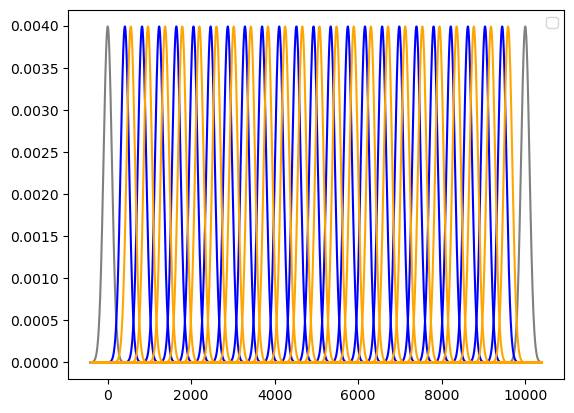

In [6]:
N = int(1e4)
mu = 0.2
lam = 0.99999
sigma=1e-2
Xs = np.arange(-4*sigma*N,N+4*sigma*N)
epsilon=0.02

def pdf(h):
    A = a(h, lam, mu)*N
    return stats.norm.pdf(Xs, A, sigma*N)

h_range=[0,1e3]
pdf_ref_left = pdf(h_range[0])
pdf_ref_right = pdf(h_range[1])

plt.plot(Xs,pdf_ref_left, color="gray")
plt.plot(Xs,pdf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pdf,h_range, epsilon, start="left")
print(hs_left)
for h in hs_left:
    _pdf = pdf(h)
    plt.plot(Xs,_pdf, color="blue")

hs_right = find_discriminable_inputs(pdf,h_range, epsilon, start="right")
print(hs_right)
for h in hs_right:
    _pdf = pdf(h)
    plt.plot(Xs,_pdf, color="orange")
plt.legend()

In [119]:
N = int(1e4)
mu = 0.2
sigma = 1e-2
Xs = np.arange(-4 * sigma * N, N + 4 * sigma * N)
epsilon = 0.2
lams = 1 - np.logspace(-4, 0, 9)
drs = np.zeros(len(lams))
nds = np.zeros(len(lams))
mis = np.zeros(len(lams))
h_range = [0, 1e3]
# attempt to match previous data analysis
logh = np.arange(-7,1.5,0.05) # 170 elements
mi_n = len(logh) 
p_h = stats.rv_discrete(values=([np.power(10,logh), np.ones(mi_n) / mi_n]))
#p_h = stats.rv_discrete(values=([np.linspace(0, 1, mi_n), np.ones(mi_n) / mi_n]))
for i, lam in enumerate(lams):

    def pmf_o_given_h(h):
        A = a(h, lam, mu) * N
        return stats.norm.pdf(Xs, A, sigma * N)

    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, epsilon, start="right")
    drs[i] = dynamic_range((hs_left[0], hs_right[0]))
    nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    # inpependent of discriminable inputs
    mis[i] = mutual_information(pmf_o_given_h, p_h)

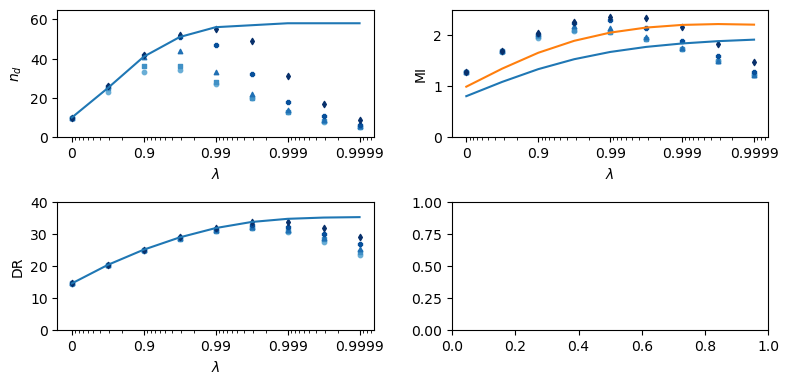

In [120]:
layout = """
AC
BD
"""
fig, axes = plt.subplot_mosaic(layout, figsize=(8, 4))
axes["A"].plot(1 - lams, nds)
axes["A"].set_xlabel("$\lambda$")
axes["A"].set_ylim(0, 65)
axes["A"].set_ylabel("$n_d$")
axes["A"].set_xscale("log")
axes["A"].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axes["A"].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
axes["A"].invert_xaxis()

axes["B"].plot(1 - lams, drs)
axes["B"].set_xlabel("$\lambda$")
axes["B"].set_ylim(0, 40)
axes["B"].set_ylabel("DR")
axes["B"].set_xscale("log")
axes["B"].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axes["B"].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
axes["B"].invert_xaxis()

axes["C"].plot(1 - lams, mis)
axes["C"].set_xlabel("$\lambda$")
axes["C"].set_ylim(0.0, 2.5)
axes["C"].set_ylabel("MI")
axes["C"].set_xscale("log")
axes["C"].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axes["C"].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
axes["C"].invert_xaxis()

# include data
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]
mainpath = "../results/FODR_withNoise_noWall/subFull"
path = mainpath + "/simu/"
path_to_MI = "../results/MI_withNoise_noWall/subFull/"
eps_list = np.logspace(-4, 0, 9).tolist()
window_list = [1, 10, 100, 1000, 10000]
n_realization = 10
colors = np.flip(pl.cm.Blues(np.linspace(1, 0, 9))[:-4], axis=0)
for n, window in enumerate(window_list):
    dr = np.zeros((len(eps_list), n_realization))
    n_d = np.zeros_like(dr)
    res = np.zeros_like(dr)
    MI = np.zeros_like(dr)
    for i, nn in enumerate(range(n_realization)):
        with open(
            path_to_MI
            + "/simu/MI_window="
            + str(window)
            + "_realization="
            + str(nn)
            + "_sigma_noise="
            + str(sigma)
            + ".pickle",
            "rb",
        ) as f:
            MI[:, nn] = pickle.load(f)
        for l, eps in enumerate(eps_list):
            df_output = pd.read_pickle(
                path
                + "/FODR_epsilon="
                + "{:.2e}".format(eps)
                + "_window="
                + str(window)
                + "_realization="
                + str(nn)
                + "_error="
                + str(epsilon)
                + "_sigma_noise="
                + str(sigma)
                + ".pkl"
            )
            dr[l, i] = np.array(df_output.loc[0, "FODR"])
            n_d[l, i] = np.array(df_output.loc[0, "no. points"])
            res[l, i] = n_d[l, i] / dr[l, i]
    axes["A"].scatter(
        eps_list,
        np.mean(n_d, axis=1),
        marker=markers[n],
        color=colors[n],
        s=10,
        label="$T=$" + legends[n],
    )
    axes["B"].scatter(
        eps_list,
        np.mean(dr, axis=1),
        marker=markers[n],
        color=colors[n],
        s=10,
        label="$T=$" + legends[n],
    )
    axes["C"].scatter(
        eps_list,
        np.mean(MI, axis=1),
        marker=markers[n],
        color=colors[n],
        s=10,
        label="$T=$" + legends[n],
    )


plt.tight_layout()

# Notes

/Users/johannes/miniforge3/envs/scipy/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


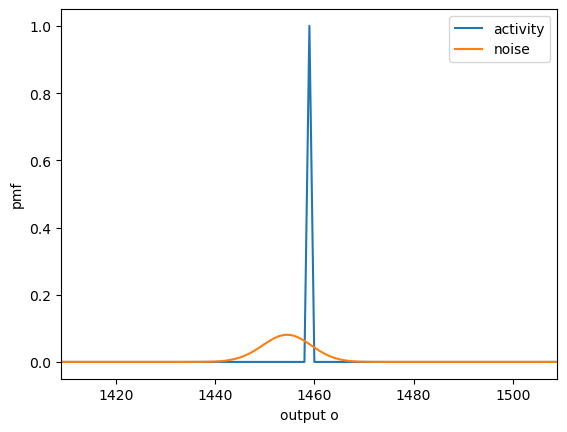

In [10]:

def dist_activity_inf(h, lam, mu):
    return stats.rv_discrete(name="activity", values=([a(h,lam,mu)],[1,]))

def pmf_output(Xs, A, p_miss, H):
    #TODO: If input is distribution then this needs first convolution
    pmf_sample = stats.binom.pmf(Xs, A, 1-p_miss)
    pmf_noise  = stats.poisson.pmf(Xs, H)
    pmf_joint = signal.convolve(pmf_sample, pmf_noise) 
    return pmf_joint

N = int(1e4)
H = 1e-3 * N
p_miss = 1e-2
A = int(a(0.5,0.5,0.2)*N)
dist_activity = stats.rv_discrete(name="activity", values=([A],[1,]))
Xs = np.arange(N+H, dtype=int)
pmf = pmf_output(Xs,A,p_miss,H)
plt.plot(Xs, dist_activity.pmf(Xs), label=dist_activity.name)
plt.plot(Xs, pmf[Xs], label="noise")
plt.xlabel("output o")
plt.ylabel("pmf")
plt.xlim([A-50,A+50])
plt.legend()

In [11]:
N = int(1e4)
p_miss = 1e-2
H = 5e-2*N
mu = 0.2
lam = 0.99
Xs = np.arange(N+int(H))
epsilon=1e-2

def pmf_output(Xs, A, p_miss, H):
    #TODO: If input is distribution then this needs first convolution
    pmf_sample = stats.binom.pmf(Xs, A, 1-p_miss)
    pmf_noise  = stats.poisson.pmf(Xs, H)
    pmf_joint = signal.convolve(pmf_sample, pmf_noise) 
    return pmf_joint

def pmf(h):
    return pmf_output(Xs, int(a(h,lam,mu)*N), p_miss, H)

hs = find_discriminable_inputs(pmf,[0,1], epsilon)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


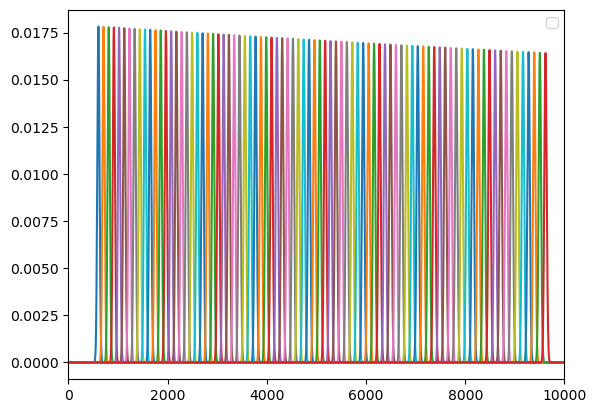

In [12]:
for h in hs:
    pmf = pmf_output(Xs, int(a(h,lam,mu)*N), p_miss, H)
    plt.plot(Xs,pmf[Xs])
plt.xlim([0,N])
plt.legend()